Disclaimer: I have created this notebook solely for my personal record keeping. However, it may also be helpful for readers interested in performing Bayesian time series analysis using PyMC in the field of marketing, specifically for media mix models (MMM).

# Introduction and Theory

When a company invests in advertising across multiple channels, it's common to see a lag in results and diminishing returns over time. To address this, media mix models are used to estimate the effectiveness of each advertising channel. The basic idea is that the company invests in various paid channels and pays them on a weekly basis, which leads to increased revenue. However, the challenge is to determine the profitability of each channel, as marketing actions typically don't produce immediate effects. Instead, there's a carryover effect where a dollar spent today will enhance revenue in the coming weeks. By using media mix models, companies can better understand which channels provide the highest return on investment and optimize their advertising strategy accordingly. One way to model this phenomenon is (see this [paper](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/46001.pdf) and this [GitHub](https://github.com/leopoldavezac/BayesianMMM) for more complicated models),

\begin{equation}
y[t] = \tau\ +\ \sum_{m=0}^{M}\beta_m \times saturation(adstock(x_m, \alpha_m), \mu_m) \ +\ 
\sum_{c=0}^{C} \gamma_c \times z_c[t]\ +\ \epsilon_t,
\end{equation}

where,
\begin{equation}
adstock(x_m, \alpha_m) = \frac {\sum_{l=0}^{L-1} \alpha_m^l \times x_m[t-l]} {\sum_{l=0}^{L-1} \alpha_m^l},
\end{equation}
and 
\begin{equation}
saturation(x_m, \mu_m) = \frac{1 - \exp(-\mu_m x_m)}{1 + \exp(-\mu_m x_m)}
\end{equation}
are the adstock and saturation functions. Here,

$y[t]$: the revenue at time $t$, <br>
$\tau$: the intercept,<br>
$M$: the number of channels,<br> 
$\beta_m$: the linear coefficient of channel $m$, <br>
$\alpha_m$: the retain rate of channel $m$, <br>
$\mu_m$: the half saturation of channel $m$, <br>
$L$: maximum duration of the effect (we here assume that $L=12$ which is reasonable given our $\alpha_m$'s and also consistent with [the main reference](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/46001.pdf)),  <br>
$x_m[t]$: the spend on the m_th media at time $t$, <br>
$C$: the number of control variables, <br>
$\gamma_c$: the linear coefficient of the control variable c, <br>
$z_c[t]$: control variable at time $t$, <br>
$\epsilon_t$: noise at time t, <br>

where we have used the geometric decay for the adstock function. 



# Data preparation

For the sake of illustration, we here use a very simple synthetic dataset. Specifically, we assume that the company  spends randomly on channel $m$, given a maximum spend value. This way, one can easily validate the algorithm.
We assume that there are three spending channels and also the following values for the actual parameters, 

revenue_max = 400000 : maximum of revenue,<br>
CH_l_max = 50000 : maximum of the spend in channel 1,<br>
CH_2_max = 30000 : maximum of the spend in channel 2,<br>
CH_3_max = 8000  : maximum of the spend in channel 3,<br>
$\tau_{\rm{act}} = 0.1$,<br>
$\beta_{1, \rm{act}} = 0.05$,<br>
$\alpha_{1, \rm{act}} = 0.4$,<br>
$\beta_{2, \rm{act}} = 0.12$,<br>
$\alpha_{2, \rm{act}} = 0.5$,<br>
$\beta_{3, \rm{act}} = 0.2$,<br>
$\alpha_{3, \rm{act}} = 0.6$,<br>
$\gamma_1 = 0.05$,<br>
$\gamma_2 = -0.1$,<br>
$\sigma = 0.05$,<br>
$\mu_m = 0$.

Note that for the sake of simplicity,  we have ignored the saturation effect here. One can easily add such effects as described in [the main reference](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/46001.pdf), the BayesianMMM
 [GitHub](https://github.com/leopoldavezac/BayesianMMM), or as in [this notebook](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html). 
One can then produce the data as following. 

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random


# Create the data set
df = pd.DataFrame()
channels = ["CH_1", "CH_2", "CH_3"]
date = pd.date_range(start='1/1/2018', periods=5000, freq='W')
df["week"] = date

# The artifial data parameters according to the above equation
L = 12 # maximum duration of the carry over effect 
REV_MAX = 400000 # maximum of revenue
CH_l_max = 50000 # maximum of the spend in channel 1
CH_2_max = 30000 # maximum of the spend in channel 2
CH_3_max = 8000  # maximum of the spend in channel 3
TAU = 0.1
BETA_1 = 0.05
ALPHA_1 = 0.4
BETA_2 = 0.12
ALPHA_2 = 0.5
BETA_3 = 0.2
ALPHA_3 = 0.6
GAMMA_1 = 0.05
GAMMA_2 = -0.1
SIGMA = 0.05
# MU_1 = 0.
# MU_2 = 0.
# MU_3 = 0.


# The spend for each channel
CH_1 = np.random.randint(0, CH_l_max, size=date.size)
CH_2 = np.random.randint(0, CH_2_max, size=date.size)
CH_3 = np.random.randint(0, CH_3_max, size=date.size)


# Control variables
TREND = df.index
SEASONAL = df["week"].dt.month

# Revenue
# adhoc function
def adhoc(alpha, x, L=12):
    w = np.array([ alpha**l for l in range(L) ])
    X = np.array([ np.concatenate((np.zeros(l), x[:x.size-l])) for l in range(L)])
    return np.dot(w/np.sum(w), X)

#saturation
# def saturation(x, mu):
#     return (1 - np.exp(-mu*x))/(1 + np.exp(-mu*x))


Y = TAU + GAMMA_2*TREND/TREND.max() + GAMMA_1*SEASONAL/SEASONAL.max() + np.random.normal(0, SIGMA, date.size)
Y += BETA_1 * adhoc(ALPHA_1, CH_1/CH_1.max()) + BETA_2 * adhoc(ALPHA_2, CH_2/CH_2.max()) + BETA_3 * adhoc(ALPHA_3, CH_3/CH_3.max()) 
# Y += BETA_1 * saturation(adhoc(ALPHA_1, CH_1/CH_1.max()), MU_1)
# Y += BETA_2 * saturation(adhoc(ALPHA_2, CH_2/CH_2.max()), MU_2)
# Y += BETA_3 * saturation(adhoc(ALPHA_3, CH_3/CH_3.max()), MU_3)  
Y = REV_MAX * Y
Y = np.round(Y)

df["revenue"] = Y
df["CH_1"] = CH_1
df["CH_2"] = CH_2
df["CH_3"] = CH_3


Note that we have used a large dataset here (data for 5000 weeks) for illustration purposes. Otherwise, one can try the model with smaller datasets to observe the widening effect for smaller datasets.

In [114]:

print(df.head(5))

# Check to see if there is any nan values
if df.isnull().values.any() == True:
    print("Alert: Check first for nan values")

# Spend channels
spend_channels = df.columns[2:]
print(spend_channels)

        week   revenue   CH_1   CH_2  CH_3
0 2018-01-07  121663.0  47131  28147  7649
1 2018-01-14  110364.0   9593   1688  3088
2 2018-01-21   97358.0   5808   2873  3891
3 2018-01-28  107705.0  17187  17283   133
4 2018-02-04  141681.0  36600   6676  7330
Index(['CH_1', 'CH_2', 'CH_3'], dtype='object')


# Preprocessing

## Scaling:

In order to make the sampler's job easier and also facilitate the prediction of the prior distributions, we should scale all the variables. Here, I normalize it to one, but one can also use standardization.

## Control variables:

A part from the spend, the revenue could also be influenced by some trends and also seasonal effects. Here, I introduce "cv_season" as the seasonal control variable, which is basically the (nomalized) month of the year, and the "cv_trend" as the trend variable which is the (normalized) passed week from the first week. Note that choosing season instead of the month does not change then results. <br><br>



In [115]:
# Preprocessing

# Creating the seasonal control variable 
month = df["week"].dt.month
df["cv_season"] = month/month.max()

# Creating the trend control variable 
df["cv_trend"] = df.index/df.index.max()

# Creating the scaled revenue
# For real data replace REV_MAX by df["revenue"].max()  
df["revenue_scaled"] = df["revenue"]/REV_MAX  

# Creating the scaled spend_channel
for spend_channel in spend_channels:
    df[spend_channel+"_scaled"] = df[spend_channel]/df[spend_channel].max()

df.head()


,week,revenue,CH_1,CH_2,CH_3,cv_season,cv_trend,revenue_scaled,CH_1_scaled,CH_2_scaled,CH_3_scaled
0,2018-01-07,121663.0,47131,28147,7649,0.083333,0.0000,0.304158,0.942639,0.938296,0.956245
1,2018-01-14,110364.0,9593,1688,3088,0.083333,0.0002,0.275910,0.191864,0.056270,0.386048
2,2018-01-21,97358.0,5808,2873,3891,0.083333,0.0004,0.243395,0.116162,0.095773,0.486436
3,2018-01-28,107705.0,17187,17283,133,0.083333,0.0006,0.269263,0.343747,0.576138,0.016627
4,2018-02-04,141681.0,36600,6676,7330,0.166667,0.0008,0.354202,0.732015,0.222548,0.916365


# Plotting

We plot the different variables to get a flavor of what we have:

The data of the first 200 weeks


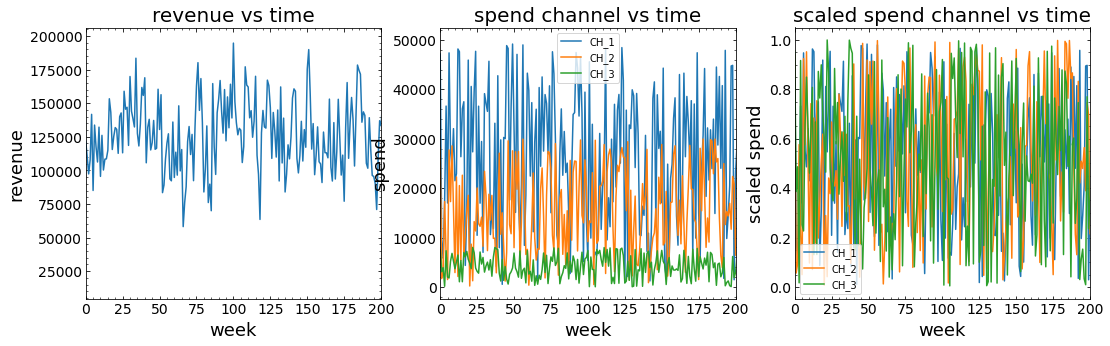

In [120]:
print("The data of the first 200 weeks")
fig = plt.figure(figsize=(18,5))

fig.add_subplot(131)
plt.plot(df.index, df["revenue"])
plt.title("revenue vs time", size=20)
plt.xlabel("week", size=18)
plt.ylabel("revenue", size=18)
plt.minorticks_on()
plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,200)

fig.add_subplot(132)
for spend_channel in spend_channels:
    plt.plot(df.index, df[spend_channel])
    
plt.title("spend channel vs time", size=20)
plt.xlabel("week", size=18)
plt.ylabel("spend", size=18)
plt.legend(spend_channels)
plt.minorticks_on()
plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,200)
    
fig.add_subplot(133)
for spend_channel in spend_channels:
    plt.plot(df.index, df[spend_channel+"_scaled"])
    
plt.title("scaled spend channel vs time", size=20)
plt.xlabel("week", size=18)
plt.ylabel("scaled spend", size=18)
plt.legend(spend_channels)
plt.minorticks_on()
plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,200)

plt.show()


# Moeling

We here model this phenomenon using PyMC. For the prior distributions, we consider that all the variables are scaled so that the suitable priors should be close to the range (-1,1). Hence, we take:

$\tau$ ~ Normal($\mu$=0, sd=1): it can take both positive and negative values,<br>
$\beta_m$ ~ HalfNormal(sd=3): since one can assume that advertising should not have a negative effect on revenue,<br>
$\alpha_m$ ~ Beta($\alpha$=3, $\beta$=3): $\alpha_m$ belongs to [0,1] by definition (Uniform(0,1) is also acceptable), <br>
$\gamma_c$ ~ Normal($\mu$=0, sd=1): it can take both positive and negative values (enhancement/reduction of revenue with control variables),<br>
$\epsilon_t$ ~ Normal($\mu$=0, sd=$\sigma$): noise, so $\sigma$~ HalfNormal(sd=1), <br>

Though the choices here are reasonable, we also tried to be consistent with the references.

In [123]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt



def adhoc(alpha, x, L=12):
    """ 
    This function calculates a_l * x[t-l] as described in the first equation.
    """
    w = tt.as_tensor_variable([tt.power(alpha,i) for i in range(L)])
    x_shifted = tt.stack([tt.concatenate([tt.zeros(i), x[:x.shape[0] - i]]) for i in range(L)])

    return tt.dot(w/tt.sum(w), x_shifted)




with pm.Model() as MMM:
    
    Y = [] # Empty list to put revenue values in
    model_variables = [] # keep track of variables sampled
    
    # intercept
    tau = pm.Normal('tau', mu=0, sd=1)
    Y.append(tau);
    model_variables.append(tau.name);
    
    # geodecay term
    for spend_channel in spend_channels:
        x = df[spend_channel+"_scaled"] 
        alpha = pm.Beta('alpha_'+spend_channel, alpha=3, beta=3)  
        beta = pm.HalfNormal('beta_'+spend_channel, sd=3)
#         mu = pm.HalfNormal('mu_'+spend_channel, sd=4)
#         Y.append(beta*saturation(adhoc(alpha, x), mu))
        Y.append(beta*adhoc(alpha, x))
        model_variables.append(alpha.name)
        model_variables.append(beta.name)
#         model_variables.append(mu.name)

        
    # control variables terms
    z1 = df["cv_season"]
    z2 = df["cv_trend"]
    gamma1 = pm.Normal('gamma1', mu=0, sd=1)
    gamma2 = pm.Normal('gamma2', mu=0, sd=1)
    Y.append(gamma1*z1) 
    Y.append(gamma2*z2)
    model_variables.append(gamma1.name)
    model_variables.append(gamma2.name)

    
    # noise
    sigma = pm.HalfNormal('sigma', sd=1)
    model_variables.append(sigma.name)
        
    # likelihooh
    y = pm.Normal('y', mu=np.sum(Y), sd=sigma, observed=df["revenue_scaled"])
    
    trace = pm.sample(5000, chains=4)
    

    
    
    

/Users/sajad/Library/Python/3.9/lib/python/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, gamma2, gamma1, beta_CH_3, alpha_CH_3, beta_CH_2, alpha_CH_2, beta_CH_1, alpha_CH_1, tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 563 seconds.


/var/folders/1v/rbvr63_x3ld3mff0bw2zmspc0000gp/T/ipykernel_58233/3213854885.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, model_variables)
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/sajad/Library/Python/3.9/lib/python/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


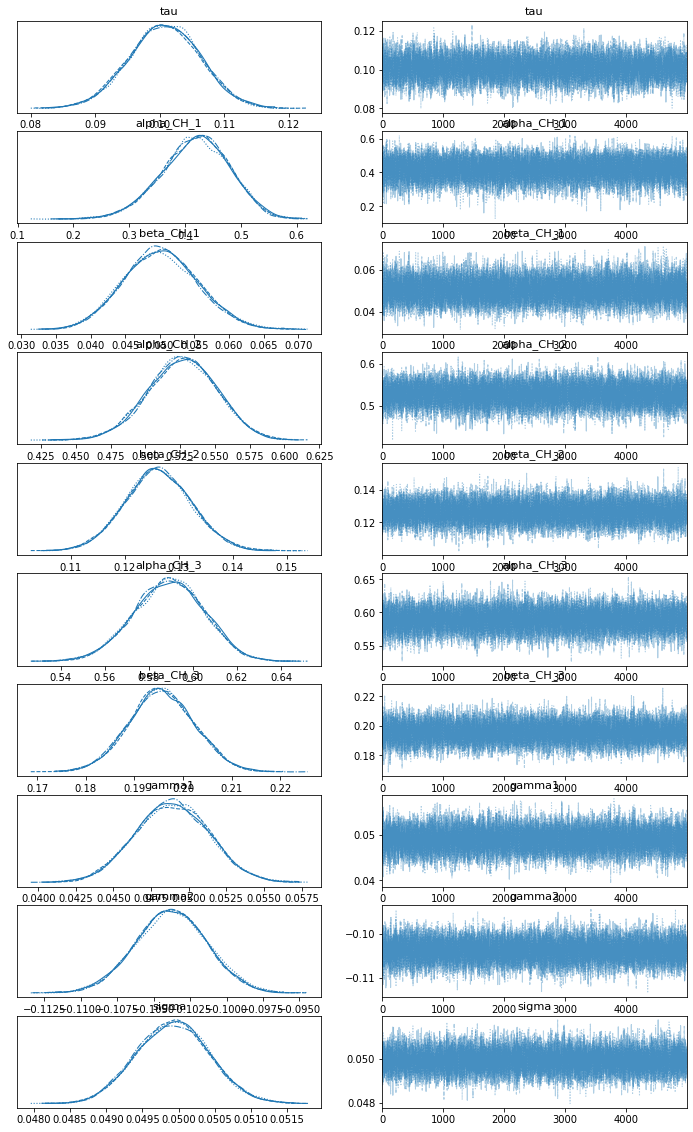

In [124]:
pm.traceplot(trace, model_variables)
plt.show()


In [88]:
# scores = pymc.geweke(trace, intervals=20)
# pymc.Matplot.geweke_plot(scores)


Considering the distributions, we can see that the convergence is approximately reached.

In [125]:
import arviz as az
print(az.summary(trace))

print("Compare with: \n", 
"TAU = ", TAU,
"\n GAMMA_1 = ", GAMMA_1,
"\n GAMMA_2 = ", GAMMA_2,
"\n ALPHA_1 = ", ALPHA_1,
"\n BETA_1 = ", BETA_1,
"\n ALPHA_2 = ", ALPHA_2,
"\n BETA_2 = ", BETA_2,
"\n ALPHA_3 = ", ALPHA_3,   
"\n BETA_3 = ", BETA_3,
"\n SIGMA = ", SIGMA )

# for var in model_variables:
#     print(var, ": ", trace[var].mean())

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/sajad/Library/Python/3.9/lib/python/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau         0.101  0.006   0.091    0.111      0.000      0.0   10445.0   
gamma1      0.049  0.002   0.044    0.053      0.000      0.0   18679.0   
gamma2     -0.104  0.002  -0.108   -0.099      0.000      0.0   17965.0   
alpha_CH_1  0.418  0.061   0.305    0.532      0.001      0.0   13869.0   
beta_CH_1   0.050  0.005   0.040    0.060      0.000      0.0   13525.0   
alpha_CH_2  0.527  0.025   0.481    0.574      0.000      0.0   14065.0   
beta_CH_2   0.126  0.006   0.115    0.138      0.000      0.0   13189.0   
alpha_CH_3  0.589  0.016   0.559    0.618      0.000      0.0   13795.0   
beta_CH_3   0.196  0.007   0.183    0.208      0.000      0.0   13196.0   
sigma       0.050  0.000   0.049    0.051      0.000      0.0   17388.0   

            ess_tail  r_hat  
tau          12000.0    1.0  
gamma1       13877.0    1.0  
gamma2       13047.0    1.0  
alpha_CH_1   12983.0    1.0  
beta_CH_1    13140.0    

# Prior Sampling vs. Posterior Sampling

Here I use the mean values of the revenue to compare them with the data. The yellow band is the results based on prior sampling and the blue band corresponds to  posterior sampling.


/Users/sajad/Library/Python/3.9/lib/python/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


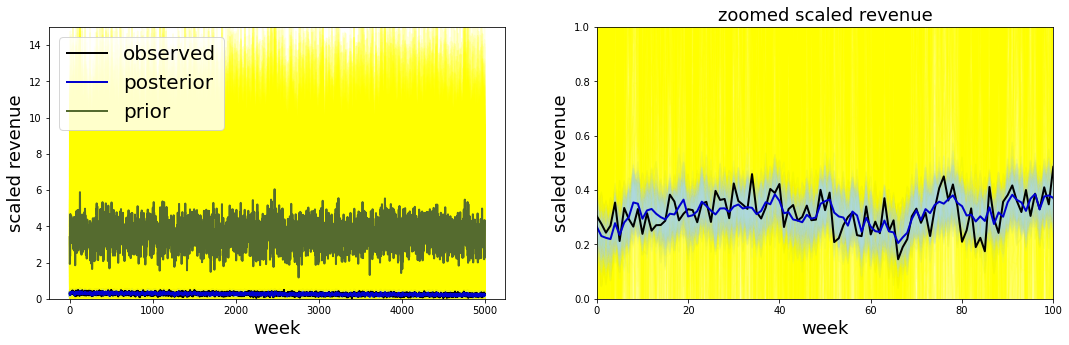

In [126]:
with MMM:
    
    sample_num = 1000
    post_pred= pm.sample_posterior_predictive(trace, samples=sample_num) # posterior predicvtive check (sample posterior predictive)
    prior_pred = pm.sample_prior_predictive(samples=sample_num, model=MMM)
    
    y_post = post_pred['y']
    y_prior = prior_pred['y']
    
    
    fig = plt.figure(figsize=(18,5)) 
    
    
    fig.add_subplot(121)
    for i in range(sample_num):
        plt.plot(df.index, y_prior[i,:], c='yellow', alpha=0.1, label='_nolegend_')
        plt.plot(df.index, y_post[i,:], c='lightblue', alpha=0.1, label='_nolegend_')
    
    plt.plot(df.index, df["revenue_scaled"],c='k',lw=2)
    plt.plot(df.index, (y_post[:,:]).mean(axis=0), c='mediumblue', lw=2)
    plt.plot(df.index, (y_prior[:,:]).mean(axis=0), c='darkolivegreen', lw=2)
    plt.ylabel("scaled revenue", size=18)
    plt.xlabel("week", size=18)
    plt.ylim(0,15)
    plt.legend(("observed", "posterior", "prior"), fontsize=20)
    
    fig.add_subplot(122)
    for i in range(sample_num):
        plt.plot(df.index, y_prior[i,:], c='yellow', alpha=0.1)
        plt.plot(df.index, y_post[i,:], c='lightblue', alpha=0.1)
    
    plt.plot(df.index, df["revenue_scaled"],c='k',lw=2)
    plt.plot(df.index, (y_post[:,:]).mean(axis=0), c='mediumblue', lw=2)
    plt.plot(df.index, (y_prior[:,:]).mean(axis=0), c='olive', lw=2)
    plt.title("zoomed scaled revenue", size=18)
    plt.ylabel("scaled revenue", size=18)
    plt.xlabel("week", size=18)
    plt.ylim(0,1)
    plt.xlim(0, 100)
    
    

In order to evaluate our results, we look at the results based on the posterior sampling as the right panel of the above figure. One can also look at the relative error as follows. It has a distribution telling us that most of the points have a relative error below 30\%.

Note that for the hist plot I only consider t >L (=12). This is because there is no data for $t <0$ and the carry over effect can not be modeled for the first few points. 

Text(0.5, 1.0, 'relative_error')

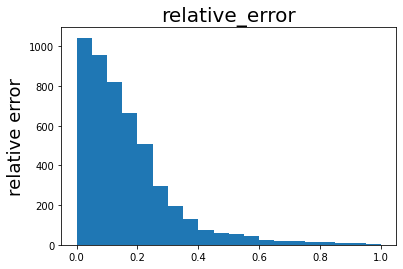

In [127]:
relative_error = abs((df["revenue_scaled"] - y_post[:,:].mean(axis=0))/df["revenue_scaled"])
plt.hist(relative_error, bins=20,range=(0,1))
plt.ylabel("relative error", size=18)
plt.title("relative_error", size=20)

Using the obtained results, one can then calculate the relevant metrics, 
\begin{equation}
ROI = \frac{revenue - spend\_channel\_m}{spend\_channel\_m}
\end{equation}

Assuming the linearity, one can say that it does not matter when to spend money. One can ignore the intercept and control terms and find :

\begin{equation}
ROI = \xi_m \times \mathrm{max(revenue)} -1
\end{equation}

<font color = 'green'> Again, channel **2** has the biggest ROI! </font>